In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading Dataset

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


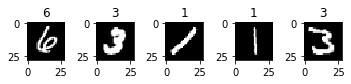

In [2]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Adding Noise

In [3]:
# Adding Noise to the dataset
def guassian_noise(image):
    r,c= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gaussian = np.random.normal(mean,sigma,(r,c))
    gaussian = gaussian.reshape(r,c)
    noisy = image + gaussian
    return noisy

def salt_and_pepper_noise(image):
    ratio = 0.9
    amount = 0.1
    noisy = np.copy(image)
    
    salt_count = np.ceil(amount * image.size * ratio)
    coords = [np.random.randint(0, i - 1, int(salt_count)) for i in image.shape]
    noisy[coords] = 1

    pepper_count = np.ceil(amount* image.size * (1. - ratio))
    coords = [np.random.randint(0, i - 1, int(pepper_count)) for i in image.shape]
    noisy[coords] = 0
    return noisy

def poisson_noise(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

def speckle_noise(image):
    r,c = image.shape
    speckle = np.random.randn(r,c)
    speckle = speckle.reshape(r,c)        
    noisy = image + image * speckle
    return noisy    

def add_noise(image):
    p = np.random.random()
    if p <= 0.25:
        #print("Guassian")
        noisy = guassian_noise(image)
    elif p <= 0.5:
        #print("SnP")
        noisy = salt_and_pepper_noise(image)
    elif p <= 0.75:
        #print("Poison")
        noisy = poisson_noise(image)
    else:
        #print("speckle")
        noisy = speckle_noise(image)
    return noisy

Corrupted Example Samples


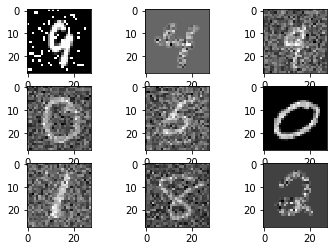

In [4]:
print ("Corrupted Example Samples")
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    noisy = add_noise(trainX[i]/255)
    plt.imshow(noisy, cmap='gray')
plt.show()

In [5]:
train_clean = [image/255 for image in trainX]
test_clean = [image/255 for image in testX]

train_noisy = [add_noise(image/255) for image in trainX]
test_noisy = [add_noise(image/255) for image in testX]

train_clean = np.reshape(train_clean, (60000, 28, 28, 1))
test_clean = np.reshape(test_clean, (10000, 28, 28, 1))

train_noisy = np.reshape(train_noisy, (60000, 28, 28, 1))
test_noisy = np.reshape(test_noisy, (10000, 28, 28, 1))

print (train_clean.shape, train_noisy.shape, test_clean.shape, test_noisy.shape)

(60000, 28, 28, 1) (60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


# Denoiser

In [6]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(128, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(256, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(256, (3,3), activation='relu')(encoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(128, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoded = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [7]:
autoencoder = tensorflow.keras.models.Model(inputs=input_data, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)        

In [9]:
autoencoder.fit(train_noisy, train_clean, epochs=30, batch_size=64, validation_data=(test_noisy, test_clean))

Epoch 1/30
938/938 [==============================] - 84s 90ms/step - loss: 0.0244 - val_loss: 0.0135
Epoch 2/30
938/938 [==============================] - 75s 80ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 3/30
938/938 [==============================] - 78s 84ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 4/30
938/938 [==============================] - 80s 85ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 5/30
938/938 [==============================] - 80s 85ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 6/30
938/938 [==============================] - 80s 85ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 7/30
938/938 [==============================] - 80s 85ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 8/30
938/938 [==============================] - 80s 85ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 9/30
938/938 [==============================] - 78s 84ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 10/30
938/938 [==============================] - 79s 84ms/step - loss: 0.006

Noisy test images


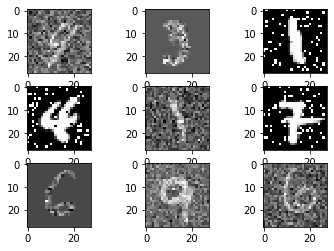

Cleaned Version(Denoising Autoencoder):) 


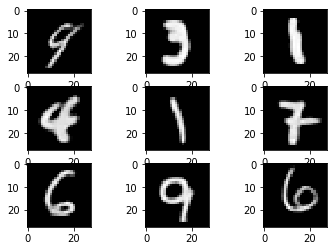

In [38]:
offset=92
# print ("Real Test Images")
# # Real Images
# for i in range(9):
#     plt.subplot(330 + 1 + i)
#     plt.imshow(test_clean[i+offset,:,:, -1], cmap='gray')
# plt.show()

print("Noisy test images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_noisy[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Cleaned Version(Denoising Autoencoder):) ")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_noisy[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()